In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import lxml
import numpy as np
from geopy.geocoders import Nominatim
import folium
import random
from decimal import Decimal
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
soup= BeautifulSoup(requests.get('https://en.wikipedia.org/wiki/List_of_London_boroughs').content,'lxml')
column_names = ['Borough','Area (sq mi)','Population','Latitude','Longitude']
df_LondonBoroughs = pd.DataFrame(columns=column_names)

for rows in soup.find_all('table')[0].find_all('tr'):
    cols = rows.find_all('td')
    if(len(cols)>1):
                df_LondonBoroughs = df_LondonBoroughs.append({'Borough':cols[0].text.strip().split('[')[0],
                                                'Area (sq mi)':cols[6].text.strip(),
                                                'Population': cols[7].text.strip(),
                                                'Latitude': float(cols[8].text.strip().split('/')[2].split('(')[0].split(';')[0]),
                                                'Longitude': float(cols[8].text.strip().split('/')[2].split('(')[0].split(';')[1].replace('\ufeff',''))}
                                                    ,ignore_index=True)

In [3]:
df_LondonBoroughs.head()

,Borough,Area (sq mi),Population,Latitude,Longitude
0,Barking and Dagenham,13.93,"194,352",51.5607,0.1557
1,Barnet,33.49,"369,088",51.6252,-0.1517
2,Bexley,23.38,"236,687",51.4549,0.1505
3,Brent,16.70,"317,264",51.5588,-0.2817
4,Bromley,57.97,"317,899",51.4039,0.0198


In [4]:
address = 'London'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [5]:
import folium

# create map of Toronto
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, population in zip(df_LondonBoroughs['Latitude'], df_LondonBoroughs['Longitude'], df_LondonBoroughs['Borough'], df_LondonBoroughs['Population']):
    label = '{}, {}'.format(population, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [6]:
CLIENT_ID = '4K5LJB4R3D0EI4QR1MOQQWKWFL12I1SXAGP40RVGVZCPN2YG' # your Foursquare ID
CLIENT_SECRET = 'YVMT1CICL2LYRMUCTZV4S0JT3GISDBZRJUWMRDEPUQY3WI5Q' # your Foursquare Secret
VERSION = '20190402'

In [7]:
def getNearbyVenues(names, latitudes, longitudes, population, area, radius=500):
    
    venues_list=[]
    for name, lat, lng, populas,ar in zip(names, latitudes, longitudes, population, area):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            populas,
            ar,
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Borough Population',
                  'Borough Area',  
                  'Venue',
                  'Venue Id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
LIMIT = 500

london_venues = getNearbyVenues(names=df_LondonBoroughs['Borough'],
                                   latitudes=df_LondonBoroughs['Latitude'],
                                   longitudes=df_LondonBoroughs['Longitude'],
                                    population=df_LondonBoroughs['Population'],
                                    area=df_LondonBoroughs['Area (sq mi)']
                                  )

In [9]:
london_venues.head()

,Borough,Borough Latitude,Borough Longitude,Borough Population,Borough Area,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,"194,352",13.93,Central Park,4ac518f8f964a520d6af20e3,51.559560,0.161981,Park
1,Barking and Dagenham,51.5607,0.1557,"194,352",13.93,Crowlands Heath Golf Course,4db54a045da3a76f444dbb00,51.562457,0.155818,Golf Course
2,Barking and Dagenham,51.5607,0.1557,"194,352",13.93,Robert Clack Leisure Centre,4dfddac1aeb7594e8624df02,51.560808,0.152704,Martial Arts Dojo
3,Barking and Dagenham,51.5607,0.1557,"194,352",13.93,Beacontree Heath Leisure Centre,4eea443a2c5bbde2183f2e7e,51.560997,0.148932,Gym / Fitness Center
4,Barking and Dagenham,51.5607,0.1557,"194,352",13.93,Morrisons Becontree Heath,4b7463caf964a52081d92de3,51.559774,0.148752,Supermarket


In [10]:
def getVenuesRating(venueIds):
    
    venues_ratings=[]
    for venueid in venueIds:
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            venueid, 
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

            
        # make the GET request
        results = requests.get(url).json()

        try:
            venues_ratings.append([venueid, result['response']['venue']['rating']])
        except:
            venues_ratings.append([venueid, 0])

    venues_rates = pd.DataFrame([item for venues_ratings in venues_ratings for item in venues_ratings])
    venues_rates.columns = ['Venue Id','Venue Rating']
    
    return(venues_rates)

In [11]:
rates=[]
for x in range(london_venues.shape[0]):
  rates.append(random.random())

df_rates = pd.DataFrame([round(Decimal(i)*10,2) for i in rates])

df_rates[0].astype('float')

0       8.93
1       5.82
2       2.28
3       9.91
4       5.19
5       5.92
6       9.97
7       3.27
8       7.95
9       4.20
10      4.75
11      9.36
12      5.59
13      3.45
14      9.19
15      5.56
16      2.20
17      0.28
18      8.03
19      9.47
20      9.58
21      5.41
22      8.83
23      9.77
24      6.01
25      2.75
26      7.40
27      1.87
28      9.43
29      4.59
        ... 
1433    9.33
1434    8.84
1435    2.79
1436    8.29
1437    8.33
1438    9.96
1439    6.89
1440    8.18
1441    2.37
1442    5.78
1443    6.78
1444    1.64
1445    0.75
1446    0.78
1447    7.09
1448    7.85
1449    1.38
1450    2.72
1451    4.96
1452    6.33
1453    1.71
1454    5.38
1455    7.11
1456    1.10
1457    7.14
1458    3.87
1459    2.66
1460    4.00
1461    0.37
1462    6.09
Name: 0, Length: 1463, dtype: float64

In [12]:
london_venues['rates'] = df_rates[0]
london_venues['Borough Population'] = london_venues['Borough Population'].str.replace(',','').astype(int)
london_venues['Borough Area'] = london_venues['Borough Area'].astype(float)
london_venues['People per sq mi'] = london_venues['Borough Population']/london_venues['Borough Area']

london_venue_groupby = london_venues.groupby('Borough').max()['People per sq mi']
london_venue_groupby=pd.DataFrame(london_venue_groupby.reset_index())
london_venue_groupby.columns=['Borough','People per sq mi']
london_venue_groupby.set_index('Borough', inplace=True)

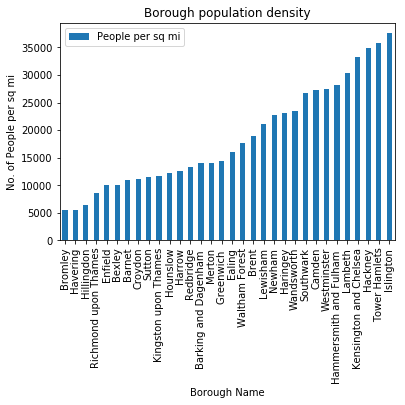

In [13]:
london_venue_groupby[['People per sq mi']].sort_values(by='People per sq mi').plot(kind='bar')
plt.ylabel('No. of People per sq mi')
plt.xlabel('Borough Name')
plt.title('Borough population density')
plt.show()

In [14]:
pd.unique(london_venues['Venue Category']).shape[0]

218

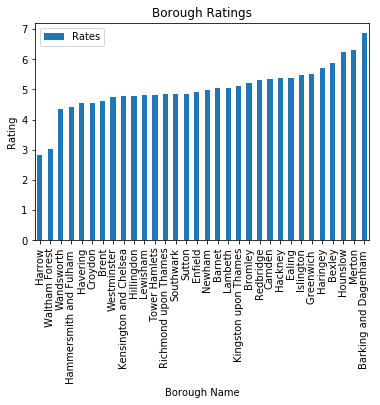

In [15]:
london_venues['rates']=london_venues['rates'].astype(float)
london_venues_avg_Borough_rating = pd.DataFrame(london_venues.groupby('Borough').mean()['rates'])
london_venues_avg_Borough_rating.columns = ['Rates']

london_venues_avg_Borough_rating[['Rates']].sort_values(by='Rates').plot(kind='bar')
plt.ylabel('Rating')
plt.xlabel('Borough Name')
plt.title('Borough Ratings')
plt.show()

In [16]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
#london_onehot.drop(labels=['Borough'], axis=1,inplace = True)
london_onehot.insert(0, 'Borough', london_venues['Borough'])
 
# move neighborhood column to the first column
#fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
#toronto_onehot = toronto_onehot[fixed_columns]
london_onehot.head()

,Borough,African Restaurant,Airport,Airport Service,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
london_grouped = london_onehot.groupby('Borough').mean().reset_index()


def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Pool,Bus Station,Golf Course,Supermarket,Park,Gym / Fitness Center,Martial Arts Dojo,Fish & Chips Shop,Furniture / Home Store,Frozen Yogurt Shop
1,Barnet,Café,Bus Stop,Home Service,Yoga Studio,Fish & Chips Shop,Garden,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
2,Bexley,Pub,Coffee Shop,Supermarket,Fast Food Restaurant,Clothing Store,Italian Restaurant,Department Store,Bakery,Furniture / Home Store,Sandwich Place
3,Brent,Hotel,Bar,Coffee Shop,Sporting Goods Shop,American Restaurant,Clothing Store,Italian Restaurant,Indian Restaurant,Sandwich Place,Grocery Store
4,Bromley,Coffee Shop,Clothing Store,Bar,Gym / Fitness Center,Burger Joint,Pizza Place,Electronics Store,Portuguese Restaurant,English Restaurant,Cosmetics Shop


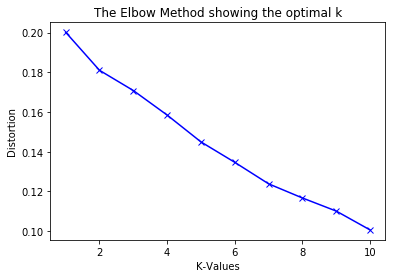

In [20]:
from scipy.spatial import distance
distortions=[]
london_grouped_clustering = london_grouped.drop('Borough', 1)
for kclusters in range(1,11):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)
    kmeans.fit(london_grouped_clustering)
    distortions.append(sum(np.min(distance.cdist(london_grouped_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1)) / london_grouped_clustering.shape[0])

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10] 

plt.plot(range(1,11), distortions, 'bx-')
plt.xlabel('K-Values')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()  

In [21]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = df_LondonBoroughs

# merge london_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Borough'), on='Borough')

london_merged.head() # check the last columns!

,Borough,Area (sq mi),Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,13.93,"194,352",51.5607,0.1557,4,Pool,Bus Station,Golf Course,Supermarket,Park,Gym / Fitness Center,Martial Arts Dojo,Fish & Chips Shop,Furniture / Home Store,Frozen Yogurt Shop
1,Barnet,33.49,"369,088",51.6252,-0.1517,5,Café,Bus Stop,Home Service,Yoga Studio,Fish & Chips Shop,Garden,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
2,Bexley,23.38,"236,687",51.4549,0.1505,0,Pub,Coffee Shop,Supermarket,Fast Food Restaurant,Clothing Store,Italian Restaurant,Department Store,Bakery,Furniture / Home Store,Sandwich Place
3,Brent,16.70,"317,264",51.5588,-0.2817,2,Hotel,Bar,Coffee Shop,Sporting Goods Shop,American Restaurant,Clothing Store,Italian Restaurant,Indian Restaurant,Sandwich Place,Grocery Store
4,Bromley,57.97,"317,899",51.4039,0.0198,2,Coffee Shop,Clothing Store,Bar,Gym / Fitness Center,Burger Joint,Pizza Place,Electronics Store,Portuguese Restaurant,English Restaurant,Cosmetics Shop


In [23]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Borough'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [24]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area (sq mi),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,23.38,0,Pub,Coffee Shop,Supermarket,Fast Food Restaurant,Clothing Store,Italian Restaurant,Department Store,Bakery,Furniture / Home Store,Sandwich Place
10,7.36,0,Pub,Coffee Shop,Café,Cocktail Bar,Brewery,Grocery Store,Clothing Store,Restaurant,Hotel,Vegetarian / Vegan Restaurant
11,6.33,0,Pub,Café,Indian Restaurant,Gastropub,Coffee Shop,Italian Restaurant,Hotel,Japanese Restaurant,Bus Stop,Chinese Restaurant
12,11.42,0,Pub,Fast Food Restaurant,Bar,Hotel Bar,Gym / Fitness Center,Grocery Store,Mediterranean Restaurant,Movie Theater,Food,Park
17,5.74,0,Pub,Bakery,Mediterranean Restaurant,Cocktail Bar,Burger Joint,Turkish Restaurant,Thai Restaurant,Theater,Ice Cream Shop,Furniture / Home Store
21,13.57,0,Supermarket,Grocery Store,Pub,Platform,Coffee Shop,Train Station,Bus Stop,Sandwich Place,Cocktail Bar,Italian Restaurant
25,22.17,0,Pub,Coffee Shop,Italian Restaurant,Grocery Store,Café,Bookstore,Indian Restaurant,Gym,Platform,Steakhouse
26,11.14,0,Pub,Coffee Shop,Italian Restaurant,Restaurant,Bar,Scenic Lookout,Grocery Store,Pizza Place,French Restaurant,English Restaurant
29,14.99,0,Pub,Coffee Shop,Vegetarian / Vegan Restaurant,Tea Room,Grocery Store,Beer Store,Trail,Concert Hall,Gym / Fitness Center,Art Gallery


In [25]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area (sq mi),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,19.49,1,Indie Movie Theater,Indian Restaurant,Convenience Store,Supermarket,Coffee Shop,Yoga Studio,Fast Food Restaurant,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint


In [26]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area (sq mi),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,16.70,2,Hotel,Bar,Coffee Shop,Sporting Goods Shop,American Restaurant,Clothing Store,Italian Restaurant,Indian Restaurant,Sandwich Place,Grocery Store
4,57.97,2,Coffee Shop,Clothing Store,Bar,Gym / Fitness Center,Burger Joint,Pizza Place,Electronics Store,Portuguese Restaurant,English Restaurant,Cosmetics Shop
5,8.40,2,Coffee Shop,Hotel,Pub,Café,Burger Joint,Bookstore,Italian Restaurant,Szechuan Restaurant,Hotel Bar,Garden
6,33.41,2,Coffee Shop,Pub,Burger Joint,Asian Restaurant,Gym / Fitness Center,Café,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery
7,21.44,2,Coffee Shop,Clothing Store,Pub,Bakery,Italian Restaurant,Bar,Pizza Place,Café,Hotel,Vietnamese Restaurant
8,31.74,2,Coffee Shop,Supermarket,Café,Clothing Store,Optical Shop,Sandwich Place,Pub,Pharmacy,Department Store,Video Game Store
9,18.28,2,Pub,Plaza,Coffee Shop,Hotel,Fast Food Restaurant,Pizza Place,Sandwich Place,Supermarket,Clothing Store,Breakfast Spot
14,43.35,2,Clothing Store,Hotel,Shopping Mall,Coffee Shop,Pub,Bookstore,Fast Food Restaurant,Bakery,Café,Gift Shop
15,44.67,2,Coffee Shop,Italian Restaurant,Clothing Store,Fast Food Restaurant,Pub,Burger Joint,Sandwich Place,Bookstore,Toy / Game Store,Pizza Place
18,4.68,2,Clothing Store,Italian Restaurant,Bakery,Hotel,Restaurant,Café,Modern European Restaurant,Pub,Garden,Burger Joint


In [27]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area (sq mi),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,14.52,3,Café,Supermarket,Park,Italian Restaurant,Coffee Shop,Grocery Store,Fast Food Restaurant,Sandwich Place,Bakery,Bar


In [28]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area (sq mi),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,13.93,4,Pool,Bus Station,Golf Course,Supermarket,Park,Gym / Fitness Center,Martial Arts Dojo,Fish & Chips Shop,Furniture / Home Store,Frozen Yogurt Shop


In [29]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area (sq mi),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,33.49,5,Café,Bus Stop,Home Service,Yoga Studio,Fish & Chips Shop,Garden,Gaming Cafe,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint


In [30]:
london_merged.loc[london_merged['Cluster Labels'] == 6, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area (sq mi),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,21.61,6,Café,Hotel,Metro Station,Park,Bed & Breakfast,Chinese Restaurant,Yoga Studio,Fish & Chips Shop,Gaming Cafe,Furniture / Home Store


In [31]:
london_merged.loc[london_merged['Cluster Labels'] == 7, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area (sq mi),Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,13.98,7,Hotel,Light Rail Station,Italian Restaurant,Airport,Airport Service,Rafting,Coffee Shop,Chinese Restaurant,Pharmacy,Food
